In [2]:
%matplotlib inline

import math
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import matplotlib.dates as pltdate
import seaborn as sns
import datetime
import time
import numpy as np
import pandas as pd
from dateutil import parser
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

In [3]:
sessionDF = pd.read_pickle('../../data/timedSessionDF.pkl')

# Visualisation

Plot return time by decive

In [571]:
def plotReturnTime(df, group=''):
    logReturnTimeBucketSize = 10 # seconds
    logMaxReturnTime = int(((df.returnTime.max()//logReturnTimeBucketSize) + 1) * logReturnTimeBucketSize)
    logMinReturnTime = int(((df.returnTime.min()//logReturnTimeBucketSize)) * logReturnTimeBucketSize)
    logReturnTimeBuckets = np.logspace(math.log(logMinReturnTime + 1,logReturnTimeBucketSize), math.log(logMaxReturnTime+logReturnTimeBucketSize, logReturnTimeBucketSize), num=100, endpoint=True, base=logReturnTimeBucketSize) - 1

    fig, ax = plt.subplots(figsize=(15, 8))

    if len(group) > 0:
        for i, group in df.groupby(group):
            ax.hist(group[group.returnTime.notnull()].returnTime, bins=logReturnTimeBuckets, histtype='step', cumulative=False, label=str(i), normed=True)
    else:
        ax.hist(df[df.returnTime.notnull()].returnTime, bins=logReturnTimeBuckets, histtype='step', cumulative=False, normed=True)
            
    ax.grid(True)
    ax.legend(loc='right')
    plt.gca().set_xscale("log")
    plt.gca().set_yscale("log")
    ax.set_xlabel('Return Time (s)')
    ax.set_ylabel('number of sessions (normalised)')


In [578]:
def plotSessionLen(df):
    logLengthBucketSizePlt = 10 # seconds
    logMaxSessionLengthPlt = int(((df.sessionLength.max()//logLengthBucketSizePlt) + 1) * logLengthBucketSizePlt)
    logSessionLengthBucketsPlt = np.logspace(0, math.log(logMaxSessionLengthPlt+logLengthBucketSizePlt, logLengthBucketSizePlt), num=100, endpoint=True, base=logLengthBucketSizePlt) - 1

    bins=logSessionLengthBucketsPlt

    #cleanDF.groupby('device').apply(lambda x: x.sessionLength.sort_values().plot(logy=True))

    fig, ax = plt.subplots(figsize=(15, 8))
    ax.set_color_cycle(['c', 'm', 'y', 'k'])
    ax.set_axis_bgcolor((1, 1, 1))

    for i, group in df.groupby('device'):
        ax.hist(group.sessionLength, bins=logSessionLengthBucketsPlt, histtype='step', cumulative=False, label=str(i))
    #    group.sessionLength.sort_values().plot(logy=True,title=str(i))
    # plot the cumulative histogram
    #ax.hist(sessionsLengthsSorted, bins=bins, histtype='step',
    #                           cumulative=False, label='Empirical')

    # tidy up the figure
    ax.grid(True)
    ax.legend(loc='right')
    plt.gca().set_xscale("log")
    plt.gca().set_yscale("log")
    ax.set_xlabel('Session length (s)')
    ax.set_ylabel('number of sessions')


# Diagnostics

In [5]:
def printMetrics(df):
    noCustomers = len(df.customerId.unique())
    noSessions = len(df)
    print('no customers:', noCustomers)
    print('no sessions:' , noSessions)
    print('sessions per customer:', noSessions/noCustomers)
    #print('means:')
    #print(df.drop(['customerId','sessionId'],axis=1).mean())

number of customers

In [6]:
printMetrics(sessionDF)

no customers: 103338
no sessions: 2868189
sessions per customer: 27.75541427161354


marker averages (from 100 samples)

In [7]:
sessionDF[['sessionLength', 'numberdivisions', 'avgPrice', 'viewonly', 'changeThumbnail', 'imageZoom', 'watchVideo', 'view360', 'sizeGuide']].sample(100).sum()

sessionLength       656.683334
numberdivisions     123.000000
avgPrice           3736.223136
viewonly            671.000000
changeThumbnail     857.000000
imageZoom           100.000000
watchVideo           53.000000
view360               2.000000
sizeGuide             0.000000
dtype: float64

sizeGuide never registered:

In [8]:
sessionDF[['imageZoom', 'watchVideo', 'view360', 'sizeGuide']].sum()

imageZoom     1555450
watchVideo    1068397
view360         32267
sizeGuide           0
dtype: int64

### Drop size guide

In [9]:
del sessionDF['sizeGuide']

### Append return time

In [542]:
def _addReturnTimeUser(x):
    x = x.sort_values('startTime')
    x['returnTime'] = (x['startTime'].shift(-1) - x['endTime']).clip(0)
    return x

def _addEndTimes(df):
    endTimeDF = df.copy()
    endTimeDF['endTime'] = endTimeDF.startTime + endTimeDF.sessionLength
    return endTimeDF

def appendReturnTime(df):
    endTimeDF = _addEndTimes(df)
    sortedSessionDF = endTimeDF.sort_values('startTime')
    returnTimeDF = sortedSessionDF.groupby('customerId').apply(_addReturnTimeUser)
    returnTimeDF = returnTimeDF.reset_index(drop=True)
    return returnTimeDF

In [543]:
returnTimeDF = appendReturnTime(sessionDF)

In [574]:
returnTimeDF.to_pickle('../../data/returnTimeDF.pkl')

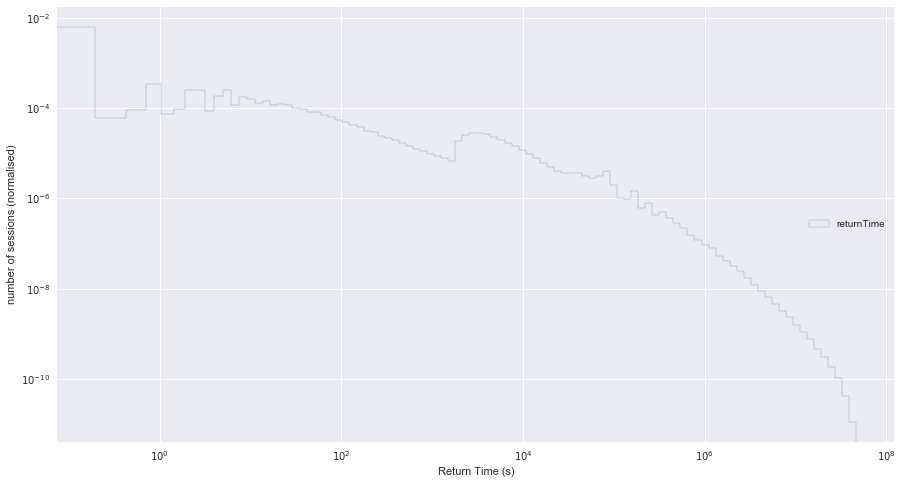

In [572]:
plotReturnTime(returnTimeDF)

### Fix device field

In [585]:
def unifyBrowsers(df):
    df = df.copy()
    df.loc[df.device.isnull(), 'device'] = 'unknown'
    df.loc[df.device.str.contains('desktop', case=False), 'device'] = 'desktop'
    df.loc[df.device.str.contains('tesktop', case=False), 'device'] = 'desktop'
    df.loc[df.device.str.contains('mobile', case=False), 'device'] = 'mobile'
    df.loc[df.device.str.contains('android', case=False), 'device'] = 'android'
    df.loc[df.device.str.contains('ios', case=False), 'device'] = 'ios'
    return df

In [586]:
unifiedBrowserDF = unifyBrowsers(returnTimeDF)

/homes/glg113/.local/lib/python3.5/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The set_color_cycle attribute was deprecated in version 1.5. Use set_prop_cycle instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/homes/glg113/.local/lib/python3.5/site-packages/ipykernel/__main__.py:12: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.


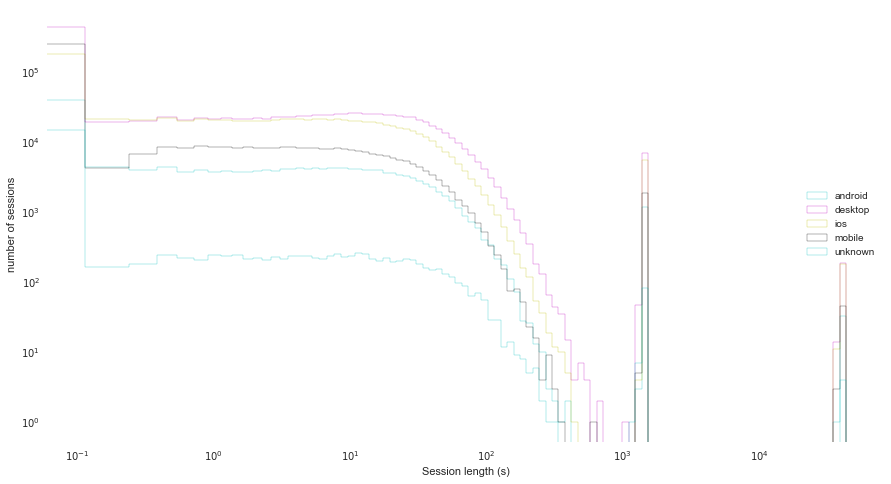

In [587]:
plotSessionLen(unifiedBrowserDF)

### Merge sessions

In [529]:
class SessionMerger:
    def __init__(self):
        self.returnTimeThreshold = 0
        self.delRows = []
        
    def _mergeRows(self, group, i, rowsToMerge):
        sumColNames = ['sessionLength','viewonly','changeThumbnail','imageZoom','watchVideo','view360']
        mergedEntry = {key: rowsToMerge[key].sum() for key in sumColNames}

        mergedEntry['customerId'] = rowsToMerge.customerId.iloc[0]
        mergedEntry['sessionId'] = 0
        mergedEntry['startTime'] = rowsToMerge.startTime.iloc[0]
        mergedEntry['startUserTime'] = rowsToMerge.startUserTime.iloc[0]
        mergedEntry['returnTime'] = rowsToMerge.returnTime.iloc[-1]
        mergedEntry['endTime'] = rowsToMerge.endTime.iloc[-1]

        mergedEntry['numberdivisions'] = rowsToMerge['numberdivisions'].max()
        mergedEntry['avgPrice'] = (rowsToMerge.viewonly * rowsToMerge.avgPrice).sum() / mergedEntry['viewonly'] # price avg by number of items viewed
        deviceStats = rowsToMerge.groupby('device').sessionLength.sum()
        if len(deviceStats) > 0:
            mergedEntry['device'] = deviceStats.argmax() # device used for longest time across sessions
        else:
            mergedEntry['device'] = np.nan

        for key in group.columns: group.set_value(i, key, mergedEntry[key])

    def _mergeUserSessions(self, group):
        currow = 0
        merge = False
        rowsToMerge = []

        for i, row in group.iterrows():
            if (not merge) and (row.returnTime < self.returnTimeThreshold):
                currow = i
                merge = True
                rowsToMerge.append(row)
            elif (merge and (row.returnTime < self.returnTimeThreshold)):
                rowsToMerge.append(row)
                self.delRows.append(i)
            elif merge:
                rowsToMerge.append(row)
                self.delRows.append(i)
                merge = False
                self._mergeRows(group, currow, pd.DataFrame.from_records(rowsToMerge))
                rowsToMerge = []

        if merge:
                self._mergeRows(group, currow, pd.DataFrame.from_records(rowsToMerge))


        return group
#         deleteRows = list(map(lambda x: x - group.index[0],self.delRows))
#         #return group.drop(group.index[deleteRows])
#         return group.drop(group.index[deleteRows])

    def mergeSessions(self, df, returnTimeThreshold):
        self.returnTimeThreshold = returnTimeThreshold
        groups = df.groupby('customerId')
        merged = groups.apply(self._mergeUserSessions)
        return merged.drop(merged.index[self.delRows])

def mergeSessions(df, returnTimeThreshold=3600):
    sessionMerger = SessionMerger()
    return sessionMerger.mergeSessions(df, returnTimeThreshold)

In [548]:
mergedSessionDF = mergeSessions(unifiedBrowserDF)

/homes/glg113/.local/lib/python3.5/site-packages/ipykernel/__main__.py:18: RuntimeWarning: invalid value encountered in double_scalars


In [549]:
mergedSessionDF.to_pickle('../../data/mergedSessionDF.pkl')

In [550]:
mergedSessionDF

,customerId,sessionId,startTime,startUserTime,sessionLength,numberdivisions,avgPrice,viewonly,changeThumbnail,imageZoom,watchVideo,view360,device,endTime,returnTime
0,2800,3127693523661746799-5489529824539830891-1.4627...,1462782849,1.462786e+09,47.816666,2,13.450000,34,132,6,0,0,desktop,1.462783e+09,3.803852e+05
1,2800,3127693523661746799-5489529824539830891-1.4631...,1463163282,1.463167e+09,0.000000,1,3.500000,1,0,0,0,0,desktop,1.463163e+09,NaN
2,4400,5145557250031124763-4382131022944021990-1.4585...,1458502351,1.458502e+09,0.000000,1,22.500000,1,2,0,0,0,mobile,1.458502e+09,2.327093e+06
3,4400,1523653375150497331-1465086463880229497-1.4608...,1460829444,1.460833e+09,0.000000,1,22.500000,1,3,0,0,0,mobile,1.460829e+09,NaN
4,4600,3955098205348603081-7606991264262984660-1.4207...,1420754771,1.420755e+09,0.000000,1,66.000000,1,0,0,0,0,mobile,1.420755e+09,2.933032e+06
5,4600,3955098205348603081-7606991264262984660-1.4236...,1423687803,1.423688e+09,0.000000,1,30.000000,1,3,0,0,0,mobile,1.423688e+09,4.577415e+06
6,4600,1257495808-1341698085-1.428265218E9,1428265218,1.428265e+09,25.333334,1,21.900000,16,0,0,0,0,ios,1.428265e+09,3.024765e+06
7,4600,3955098205348603081-7606991264262984660-1.4312...,1431290008,1.431294e+09,0.266667,1,8.000000,2,0,0,0,0,mobile,1.431290e+09,1.006734e+07
8,4600,1257495808-1341698085-1.441357114E9,1441357351,1.441357e+09,0.516667,1,26.250000,2,0,0,0,0,ios,1.441357e+09,2.912805e+06
9,4600,1257495808-1341698085-1.444269935E9,1444270157,1.444252e+09,0.683333,1,46.666668,3,0,0,0,0,ios,1.444270e+09,1.180708e+06


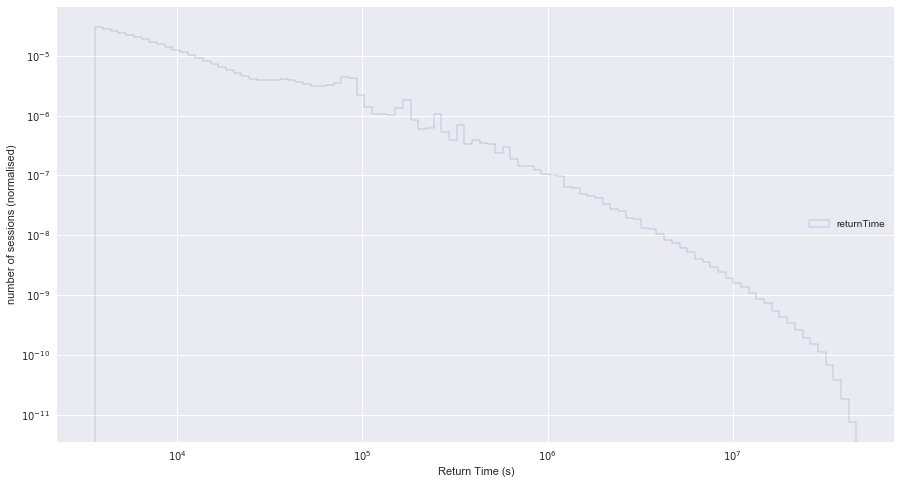

In [573]:
plotReturnTime(mergedSessionDF)

/homes/glg113/.local/lib/python3.5/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The set_color_cycle attribute was deprecated in version 1.5. Use set_prop_cycle instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/homes/glg113/.local/lib/python3.5/site-packages/ipykernel/__main__.py:12: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.


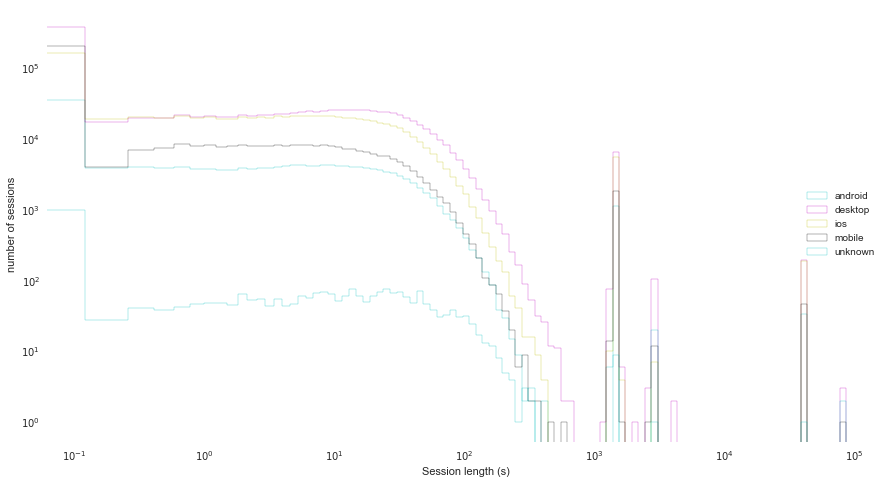

In [581]:
plotSessionLen(mergedSessionDF)

# Split

In [590]:
def makeunixtime(val):
    try:
        return int(time.mktime(parser.parse(val).timetuple()))
    except (OverflowError, AttributeError, ValueError):
        return None


def unixtimetostr(val):
        return datetime.datetime.fromtimestamp(int(val)).strftime('%Y-%m-%d %H:%M:%S')

In [591]:
trainPeriod = ["2015-02-01", "2016-02-01"]
testPeriod = ["2016-02-01", "2016-04-01"]

In [601]:
trainDF = mergedSessionDF[(mergedSessionDF['startTime'] > makeunixtime(trainPeriod[0])) & (mergedSessionDF['startTime'] < makeunixtime(trainPeriod[1]))]
predDF = mergedSessionDF[(mergedSessionDF['startTime'] > makeunixtime(testPeriod[1])) & (mergedSessionDF['startTime'] < makeunixtime(testPeriod[1]))]

In [615]:
trainTargetDF = mergedSessionDF[(mergedSessionDF['startTime'] > makeunixtime(trainPeriod[0])) & (mergedSessionDF['startTime'] < makeunixtime(trainPeriod[1]))]
trainTargetDF = trainTargetDF.groupby('customerId').last()

In [616]:
trainTargetDF.to_pickle('../../data/trainFebToFebTargetsMergedDF.pkl')

In [604]:
trainDF['observed'] = (trainDF['startTime'] + trainDF['sessionLength'] + trainDF['returnTime']) < makeunixtime(trainPeriod[1])
trainDF['returnTime'] = pd.DataFrame([trainDF['returnTime'], makeunixtime(trainPeriod[1]) - trainDF['startTime'] + trainDF['sessionLength']]).min()

/homes/glg113/.local/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/homes/glg113/.local/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


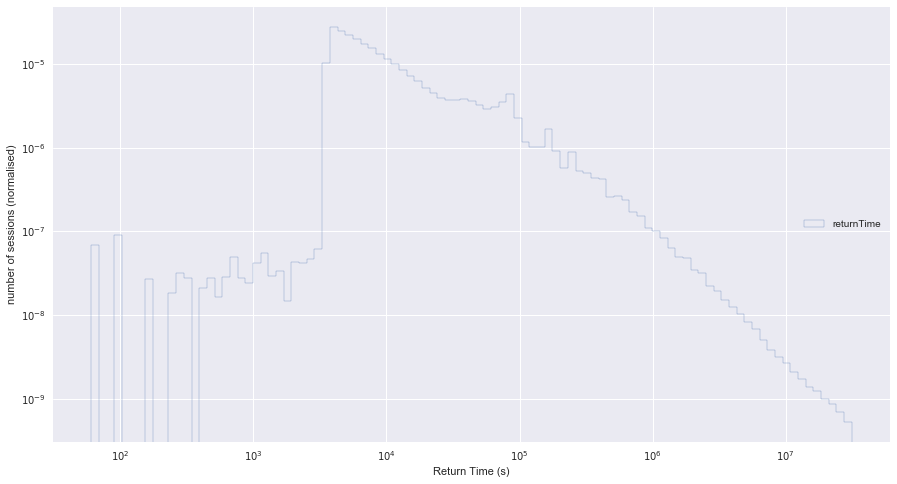

In [606]:
plotReturnTime(trainDF)

In [607]:
trainDF

,customerId,sessionId,startTime,startUserTime,sessionLength,numberdivisions,avgPrice,viewonly,changeThumbnail,imageZoom,watchVideo,view360,device,endTime,returnTime,observed
5,4600,3955098205348603081-7606991264262984660-1.4236...,1423687803,1.423688e+09,0.000000,1,30.000000,1,3,0,0,0,mobile,1.423688e+09,4.577415e+06,True
6,4600,1257495808-1341698085-1.428265218E9,1428265218,1.428265e+09,25.333334,1,21.900000,16,0,0,0,0,ios,1.428265e+09,3.024765e+06,True
7,4600,3955098205348603081-7606991264262984660-1.4312...,1431290008,1.431294e+09,0.266667,1,8.000000,2,0,0,0,0,mobile,1.431290e+09,1.006734e+07,True
8,4600,1257495808-1341698085-1.441357114E9,1441357351,1.441357e+09,0.516667,1,26.250000,2,0,0,0,0,ios,1.441357e+09,2.912805e+06,True
9,4600,1257495808-1341698085-1.444269935E9,1444270157,1.444252e+09,0.683333,1,46.666668,3,0,0,0,0,ios,1.444270e+09,1.180708e+06,True
10,4600,1257495808-1341698085-1.445450772E9,1445450866,1.445451e+09,0.000000,1,45.000000,2,0,0,0,0,ios,1.445451e+09,4.187790e+05,True
11,4600,3955098205348603081-7606991264262984660-1.4458...,1445869645,1.445870e+09,0.000000,1,70.000000,1,0,0,0,0,mobile,1.445870e+09,9.997500e+04,True
12,4600,3955098205348603081-7606991264262984660-1.4459...,1445969620,1.445970e+09,0.000000,1,70.000000,1,0,0,0,0,mobile,1.445970e+09,8.441940e+05,True
13,4600,5371143799284085389-3809498348446746724-1.4468...,1446813814,1.446814e+09,23.250000,1,20.372500,4,6,0,1,0,desktop,1.446814e+09,1.030227e+06,True
14,4600,5371143799284085389-3809498348446746724-1.4478...,1447844064,1.447844e+09,1.466667,2,23.247500,4,9,0,0,0,desktop,1.447844e+09,7.984515e+05,True


In [608]:
trainDF.to_pickle('../../data/trainFebToFebCensoredMergedDF.pkl')

In [609]:
testDF.to_pickle('../../data/testFebToFebCensoredMergedDF.pkl')

### Clear NaNs

number of session with NaN entries:

In [575]:
len(sessionDF[pd.isnull(sessionDF).any(axis=1)])

60011

identify null columns:

In [576]:
for column in sessionDF:
    print(column, sessionDF[column].isnull().sum())

customerId 0
sessionId 0
startTime 0
startUserTime 37789
sessionLength 0
numberdivisions 0
avgPrice 0
viewonly 0
changeThumbnail 0
imageZoom 0
watchVideo 0
view360 0
device 22984


number of users with missing device or missing startUserTime:

In [29]:
len(sessionDF[sessionDF.device.isnull() | sessionDF.startUserTime.isnull()].customerId.unique())

18228

In [30]:
len(sessionDF[sessionDF.device.isnull()].customerId.unique())

8456

In [31]:
len(sessionDF[sessionDF.startUserTime.isnull()].customerId.unique())

13575

In [36]:
sessionDF.groupby('customerId').filter(lambda x: x.startUserTime.isnull().any())

,customerId,sessionId,startTime,startUserTime,sessionLength,numberdivisions,avgPrice,viewonly,changeThumbnail,imageZoom,watchVideo,view360,device
2,98200,1787464517350918804-425614014228134501-1.45996...,1459963048,1.459967e+09,0.000000,1,30.000000,1,2,0,0,0,desktop com
3,115200,3000177380253832313-6917530143796253474-1.4386...,1438682910,1.438687e+09,16.533333,1,35.665333,15,15,0,0,0,desktop com
4,137800,2908040666771364789-4189600297957985454-1.4512...,1451242320,1.451242e+09,0.266667,1,20.000000,2,8,0,0,0,mobile com
6,191800,3001084653438547590-6917530730596408371-1.4238...,1423843103,1.423822e+09,0.300000,1,31.500000,2,1,0,0,0,desktop us
8,205600,2328638763899782260-2473308463657645770-1.4663...,1466334622,1.466338e+09,0.000000,1,17.500000,1,1,0,0,0,mobile com
9,229000,7827127855765176388-6306651120121982219-1.4548...,1454803648,1.454804e+09,0.650000,1,34.298000,6,0,0,0,0,iOS
10,260200,3781007145-505005817-1.458390302E9,1458390953,1.458391e+09,3.350000,1,27.222221,18,0,0,0,0,iOS
11,260200,4919939620662291835-2319474913974848175-1.4483...,1448393072,1.448393e+09,24.700000,1,91.428570,7,4,0,0,0,desktop com
12,268600,147604313-470640468-1.424554326E9,1424554356,1.424554e+09,13.216666,1,46.666668,9,0,0,0,0,iOS
13,268600,147604313-470640468-1.428740499E9,1428740585,1.428741e+09,0.000000,1,15.000000,1,0,0,0,0,iOS
